## Crowded field photometry --- 3. Photoutils on NIRISS images

This notebook demonstrates photometry on reduced NIRISS images (_i2d.fits; after image3 pipeline).

One of distinguished features in this notebook from other notebooks is the scene in in a crowded region, a luster of galaxies, and some parameters of photutils may need to be changed.


## To Do:
- 1.Load input image
- 2.Run photutils on the image to detect sources.
- 3.Deblend detected sources. 
- 4.Compare measured fluxes with input ones.


### Requirement:
- photutils

The documentation of photutils may also be helpful;
https://photutils.readthedocs.io/en/stable/segmentation.html#image-segmentation

#### 1. Load image;

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Reduction directory set in 2a notebook;
DIR_RED = './reduction/'

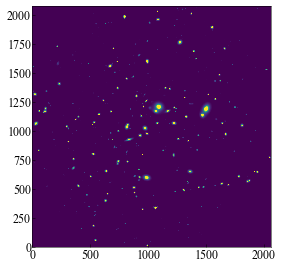

In [3]:
image3 = '%sl3_nis_f200w_i2d.fits'%DIR_RED
data   = fits.open(image3)[1].data
plt.imshow(data,vmin=0,vmax=1.)

#### 2. Run Photutils --- a python package for photometry.

Let’s find sources that have 5 connected pixels that are each greater than the corresponding pixel-wise threshold level defined above (i.e. 2 sigma per pixel above the background noise). 

Note that by default “connected pixels” means “8-connected” pixels, where pixels touch along their edges or corners. 

One can also use “4-connected” pixels that touch only along their edges by setting connectivity=4 in detect_sources().

We will also input a 2D circular Gaussian kernel with a FWHM of 3 pixels to smooth the image some prior to thresholding:

In [4]:
# Measure background noise and set a detection threshold;
from photutils import detect_threshold
threshold = detect_threshold(data, nsigma=2.)

In [5]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 2.0 * gaussian_fwhm_to_sigma  #
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

Text(0.5, 1.0, 'Segmentation Image')

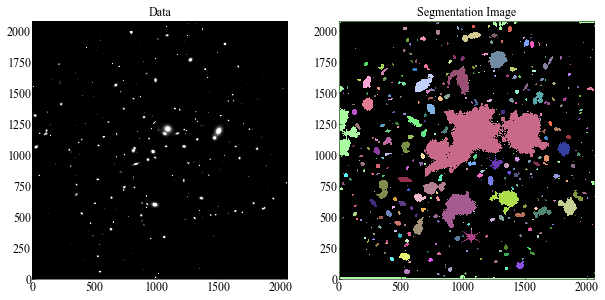

In [6]:
# Show segmentatin map;

import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', vmin=0,vmax=1.0)
ax1.set_title('Data')

cmap = segm.make_cmap(random_state=12345)
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')

### 3. Source Deblending
In the example above, overlapping sources are detected as single sources (same color in the map). 

Separating those sources requires a deblending procedure, such as a multi-thresholding technique used by SExtractor. 

In [7]:
from photutils import deblend_sources

contrast = 0.0001
nlevel   = 64
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel, nlevels=nlevel,
                               contrast=contrast)

Text(0.5, 1.0, 'Deblended segmentation Image')

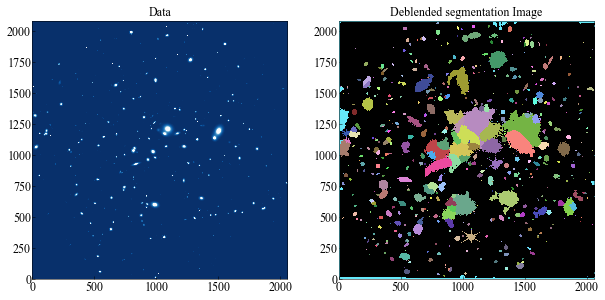

In [8]:
# Take a look at the deblended seg map;
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Blues_r', vmin=0,vmax=1.0)
ax1.set_title('Data')

cmap = segm_deblend.make_cmap(random_state=12345)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
ax2.set_title('Deblended segmentation Image')

#### Much better. What about closer look?

(900, 1400)

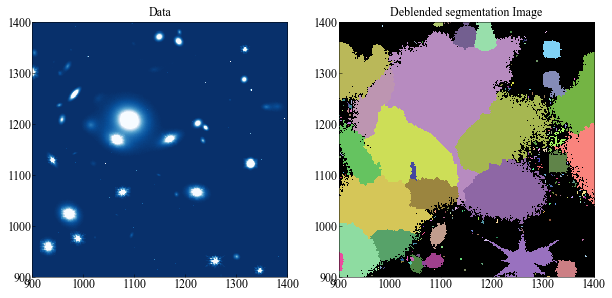

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Blues_r', vmin=0,vmax=1.0)
ax1.set_title('Data')

cmap = segm_deblend.make_cmap(random_state=12345)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
ax2.set_title('Deblended segmentation Image')

ax1.set_xlim(900,1400)
ax1.set_ylim(900,1400)
ax2.set_xlim(900,1400)
ax2.set_ylim(900,1400)

#### While there are some faint galaxies still blending, overall it looks good.

### 4.Measuring source position, flux, and morphology
by using source_properties() function.

In [10]:
# To get sky position, wcs is needed.
from astropy.wcs import WCS
hdu = fits.open(image3)[1]
wcs = WCS(hdu.header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 3.588182091381559  -30.39733691277704  
CRPIX : 1029.374673360949  1037.933986307246  
PC1_1 PC1_2  : 0.6367181849242758  -0.7710965912171676  
PC2_1 PC2_2  : -0.7710965912171676  -0.6367181849242758  
CDELT : 1.82334145283364e-05  1.82334145283364e-05  
NAXIS : 2057  2074

In [11]:
from photutils import source_properties
cat = source_properties(data, segm_deblend,wcs=wcs)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['cxx'].info.format = '.2f'
tbl['cxy'].info.format = '.2f'
tbl['cyy'].info.format = '.2f'
tbl['gini'].info.format = '.2f'

tbl

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float32,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,255.00,16.00,"3.594412860421505,-30.374610751187454","3.594412860421505,-30.374610751187454",6.2718544,None,None,None,None,254.0,256.0,15.0,17.0,-0.080255926,6.8501997,254.0,16.0,255.0,16.0,9.0,1.692568750643269,8.0,0.28867513459481287,0.28867513459481287,0.0,0.0,0.0,1.0,0.08333333333333333,0.0,0.08333333333333333,12.00,0.00,12.00,1.08
2,1709.00,18.00,"3.6139516075688607,-30.39507442618828","3.6139516075688607,-30.39507442618828",-0.3751797,None,None,None,None,1708.0,1710.0,17.0,19.0,-0.06963384,0.06360653,1709.0,17.0,1709.0,18.0,8.0,1.5957691216057308,7.414213562373095,0.28867513459481287,0.28867513459481287,0.0,0.0,0.0,1.0,0.08333333333333333,0.0,0.08333333333333333,12.00,0.00,12.00,-0.08
3,845.44,27.51,"3.6021717971642624,-30.3830451668933","3.6021717971642624,-30.3830451668933",-9.009923,None,None,None,None,838.0,853.0,19.0,36.0,-0.060937934,0.020413915,842.0,20.0,845.0,27.0,205.0,8.07796550300118,53.112698372208094,0.756736513740976,0.49878016174525014,-66.83396140279183,0.7520377926753451,0.34088001214650243,1.517174442329717,0.2989039361431707,-0.11713575966117944,0.5225278648362934,3.67,1.64,2.10,-0.19
4,1994.21,21.00,"3.61774266473702,-30.39911839160165","3.61774266473702,-30.39911839160165",0.45774597,None,None,None,None,1993.0,1996.0,19.0,22.0,-0.06745851,0.86745256,1993.0,22.0,1994.0,21.0,13.0,2.0342144725641096,10.82842712474619,0.4976562724387088,0.28867513459481287,0.0,0.8145671158444089,0.4199306819138585,1.7239318971383657,0.24766176549759034,0.0,0.08333333333333333,4.04,-0.00,12.00,1.96
5,483.01,22.84,"3.5973699397985004,-30.37789581580521","3.5973699397985004,-30.37789581580521",-0.16218267,None,None,None,None,482.0,485.0,21.0,24.0,-0.07036832,0.38992,485.0,23.0,483.0,23.0,13.0,2.0342144725641096,10.82842712474619,0.4646229238253462,0.3097558716126713,89.03731115646477,0.7453420244886871,0.33331771695124124,1.4999648639633396,0.09598255308169536,0.0020146242185005827,0.21584060826084384,10.42,-0.19,4.63,1.66
6,699.93,23.00,"3.600286797488007,-30.380947167735275","3.600286797488007,-30.380947167735275",-0.47115555,None,None,None,None,698.0,701.0,22.0,24.0,-0.070045434,0.06267247,701.0,24.0,700.0,23.0,11.0,1.8712051592547776,9.414213562373096,0.3878236182434223,0.28867513459481287,0.0,0.6677936492944507,0.2556535470884542,1.3434604223456073,0.1504071588674198,0.0,0.08333333333333333,6.65,-0.00,12.00,-0.18
7,876.43,24.92,"3.602631196495087,-30.383450876956207","3.602631196495087,-30.383450876956207",49.8913,None,None,None,None,875.0,878.0,23.0,26.0,-0.07092561,26.43614,876.0,26.0,876.0,25.0,16.0,2.256758334191025,12.0,0.4957168230454415,0.2690572093179749,-0.15165048876686935,0.8398853017341152,0.4572360734803812,1.8424216333099541,0.2457339542869835,-0.00045880319245274426,0.07239299624925866,4.07,0.05,13.81,0.93
8,50.00,26.00,"3.5914911907628637,-30.371844709878008","3.5914911907628637,-30.371844709878008",-0.3864793,None,None,None,None,49.0,51.0,25.0,27.0,-0.0694178,0.014013555,49.0,26.0,50.0,26.0,8.0,1.5957691216057308,7.414213562373095,0.28867513459481287,0.28867513459481287,0.0,0.0,0.0,1.0,0.08333333333333333,0.0,0.08333333333333333,12.00,0.00,12.00,-0.25


### Let's use measured morp properties;

In [12]:
import astropy.units as u
from photutils import source_properties, EllipticalAperture

r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    if not np.isnan(position).any():
        a = obj.semimajor_axis_sigma.value * r
        b = obj.semiminor_axis_sigma.value * r
        theta = obj.orientation.to(u.rad).value
        apertures.append(EllipticalAperture(position, a, b, theta=theta))

(900, 1400)

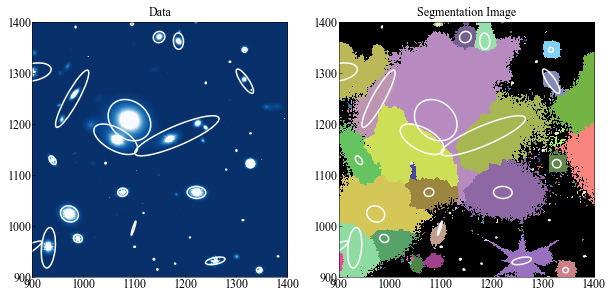

In [13]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Blues_r', vmin=0, vmax=1)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(random_state=12345)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)
    
ax1.set_xlim(900,1400)
ax1.set_ylim(900,1400)
ax2.set_xlim(900,1400)
ax2.set_ylim(900,1400)

### Let's compare flux from input catalog;

In [14]:
# Cross match function
def cross_match(data1,data2,limmag=25):
    '''
    Purpose:
    ========
    Calculate shift between two catalogs.
    No rotation?
    
    Originally referred to here:
    https://docs.astropy.org/en/stable/coordinates/matchsep.html
    '''
    
    limmag = 25.

    id1 = data1['id']
    ra1 = data1['ra']
    dec1= data1['dec']
    mag1= data1['mag']

    id2 = data2['id']
    ra2 = data2['ra']
    dec2= data2['dec']
    mag2= data2['mag']

    from astropy.coordinates import SkyCoord
    from astropy import units as u

    con  = (mag1<limmag)
    con2 = (mag2<limmag)

    # Define new arrays;
    index= np.zeros(len(ra1),dtype='int') # index number of data2 that corresponds to data1.
    delr = np.zeros(len(ra1),dtype='float32') +1000 # Distance between cross matched objects    

    for ii in range(len(ra1)):
        c = SkyCoord(ra=ra1[ii]*u.degree, dec=dec1[ii]*u.degree)
        catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)
        index[ii]  = idx
        delr[ii] = d2d.value[0]
    
    # Exclude duplicated detection;
    for ii in range(len(ra1)):
        con_tmp = (index[:] == index[ii])
        if delr[ii] > np.min(delr[con_tmp]):
            delr[ii]   = 1000
            index[ii]  = 0 # Reset;
    tab = {'id':id1,'iix':index,'delr':delr}
    
    return tab

### Let's start with the point source catalog;

In [15]:
from astropy.io import ascii

# This is the input catalog;
fd1 = ascii.read('./sources_point_01.cat')
fd1

index,x_or_RA,y_or_Dec,niriss_f115w_magnitude,niriss_f150w_magnitude,niriss_f090w_magnitude,niriss_f200w_magnitude
int64,float64,float64,float64,float64,float64,float64
31,3.57189905,-30.37739567,21.7,21.447,22.108,21.358
77,3.58918184,-30.37894758,23.057,22.854,23.351,22.799
172,3.57028826,-30.38076521,23.563,23.535,23.652,23.524
204,3.57785645,-30.38120658,24.115,23.886,24.266,23.636
311,3.59369407,-30.38317301,25.046,24.997,25.042,24.788
364,3.60421616,-30.38566195,22.424,22.401,22.481,22.386
384,3.57301811,-30.38530305,20.384,19.804,21.059,19.595
472,3.57952704,-30.38625461,25.208,25.062,25.594,24.986
637,3.60005197,-30.38971551,18.443,17.979,18.972,17.845


In [16]:
data1 = {'id':fd1['index'],'ra':fd1['x_or_RA'],'dec':fd1['y_or_Dec'],'mag':fd1['niriss_f200w_magnitude']}

In [17]:
# Convert Mirage flux to something that makes sense to me...

PHOTUJA2 = hdu.header['PHOTUJA2'] # Flux density (uJy/arcsec2) producing 1 cps 
PIXAR_A2 = hdu.header['PIXAR_A2'] # Nominal pixel area in arcsec^2
# Magnitude zeropoint
mag0 = 23.9 #uJy to ABmag

mag = -2.5 * np.log10(tbl['source_sum']*PHOTUJA2*PIXAR_A2) + mag0
con_mag = (tbl['source_sum']<=0)
mag[con_mag] = 99

con = (np.isnan(tbl['sky_centroid'].ra.value))
data2 = {'id':tbl['id'][~con],'ra':tbl['sky_centroid'].ra.value[~con], 'dec':tbl['sky_centroid'].dec.value[~con], 'mag':mag[~con]}

In [18]:
tab = cross_match(data1,data2,limmag=25)

### Compare magnitude;

In [19]:
delr= tab['delr']
iix = tab['iix']
con_plot = (delr<10)

mag1 = data1['mag']
mag2 = data2['mag']

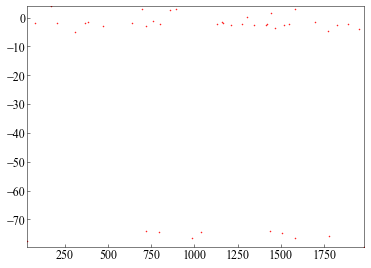

In [20]:
plt.plot(tab['id'][con_plot],(mag1[:]-mag2[iix])[con_plot],marker='.',ms=1,linestyle='')

Text(0.5, 0, 'Index_input')

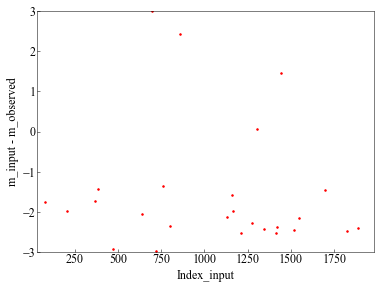

In [21]:
plt.plot(tab['id'][con_plot],(mag1[:]-mag2[iix])[con_plot],marker='.',ms=3,linestyle='')
plt.ylim(-3,3)
plt.ylabel('m_input - m_observed')
plt.xlabel('Index_input')

### Then do with the extended source catalog;

In [22]:
# This is the input catalog;
fd1 = ascii.read('./sources_extend_01.cat')
fd1

index,x_or_RA,y_or_Dec,radius,ellipticity,pos_angle,sersic_index,niriss_f115w_magnitude,niriss_f150w_magnitude,niriss_f090w_magnitude,niriss_f200w_magnitude
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10002,3.57321015,-30.3757644,2.23,0.32,165.3,4.0,18.757,99.0,19.297,18.737
10004,3.57472077,-30.37612586,0.628,0.362,26.3,1.0,25.105,24.978,25.452,24.83
10008,3.57437262,-30.37948344,0.467,0.64,30.2,1.0,24.766,24.647,25.149,24.558
10009,3.57666845,-30.37611802,1.132,0.314,88.5,1.0,24.191,24.012,24.897,23.98
10010,3.576504,-30.37705428,0.833,0.273,41.6,1.0,24.478,24.093,24.585,23.998
10011,3.57371352,-30.37681497,0.611,0.053,5.1,1.0,22.888,22.683,23.194,22.567
10014,3.57606911,-30.37645631,0.289,0.157,123.7,1.0,24.849,24.549,25.005,24.486
10016,3.57508315,-30.37707299,0.595,0.609,113.8,4.0,18.952,18.553,19.423,18.416
10017,3.57346089,-30.37792779,0.442,0.243,140.1,4.0,20.328,19.962,20.768,19.845


In [23]:
data1 = {'id':fd1['index'],'ra':fd1['x_or_RA'],'dec':fd1['y_or_Dec'],'mag':fd1['niriss_f200w_magnitude']}
tab = cross_match(data1,data2,limmag=25)

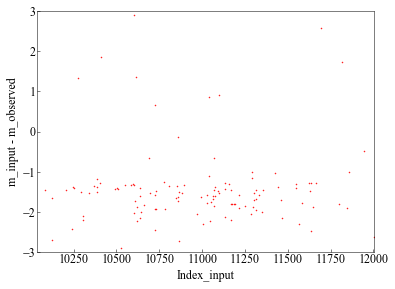

In [26]:
delr= tab['delr']
iix = tab['iix']
con_plot = (delr<10)

mag1 = data1['mag']
mag2 = data2['mag']

plt.plot(tab['id'][con_plot],(mag1[:]-mag2[iix])[con_plot],marker='.',ms=1,linestyle='')

plt.ylim(-3,3)
plt.ylabel('m_input - m_observed')
plt.xlabel('Index_input')

plt.savefig('mm_extended.png')

### What about pipeline catalog?;

In [27]:
# This is the input catalog;
fd3 = ascii.read('%sl3_nis_f200w_cat.ecsv'%DIR_RED)
fd3

id,xcentroid,ycentroid,sky_centroid,area,source_sum,source_sum_err,semimajor_axis_sigma,semiminor_axis_sigma,orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur,orientation_sky,abmag,abmag_error
,pix,pix,"deg,deg",pix2,,,pix,pix,deg,"deg,deg","deg,deg","deg,deg","deg,deg",deg,,
int64,float64,float64,object,float64,float32,float32,float64,float64,float64,object,object,object,object,float64,float64,float32
1,131.11425385885784,1145.7587996463203,"3.574332897393595,-30.385984355666015",85768.0,3261.6716,2.7705297,379.9591051272728,217.09633480144436,-27.5326295869867,"3.5912434667584208,-30.37082704705949","3.5574216784607358,-30.3949132864681","3.6189452519492127,-30.399758387836336","3.585120275483464,-30.423851763987805",112.91983457597021,18.766447067260742,0.0009222462
2,nan,nan,"nan,nan",143.0,-7.0647984,0.031841714,nan,nan,nan,"3.6057313119319367,-30.38630438147852","3.6054705674673904,-30.38649016880254","3.6059063022457605,-30.386487134373024","3.605645557626569,-30.386672922044813",nan,nan,-0.0048935153
3,845.3336589024647,27.499158245660013,"3.6021705732133116,-30.383043581230282",174.0,-7.184681,0.036958903,0.5284596715652646,0.43938628363831084,-54.36011311627946,"3.6022089507148674,-30.382854631194135","3.6019319123474394,-30.383052022771192","3.6024108479441477,-30.38306550531336","3.6021338093869946,-30.383262897316783",86.09235104667746,nan,-0.0055851634
4,796.6357009111301,39.20049977500462,"3.6013244233794803,-30.382494836113796",318.0,-4.2896156,0.10268607,2.1430795822570845,1.6628183672261048,-6.905045642844287,"3.601316327925605,-30.38223726320799","3.601006696674699,-30.382457875179266","3.601639358787762,-30.382574663845354","3.6013297271975406,-30.38279527657903",133.54741852011261,nan,-0.025990669
5,1017.6802764682864,44.38033581491001,"3.6042152781395806,-30.385662475971877",257.0,27.111122,0.23725678,1.3670051602214288,1.3394317670349214,75.42237276808368,"3.6042229659247,-30.385416246500366","3.6039133311675737,-30.385636865332174","3.604492175276997,-30.385697407796254","3.60418254023726,-30.385918027263404",215.8748369310406,23.967178344726562,0.009501571
6,546.2836005605163,58.83804182796836,"3.5976348851926927,-30.37920325540562",1397.0,197.91281,0.5855243,4.966004010365373,3.819066207666278,-12.478940815160582,"3.5976299287330047,-30.378644359071316","3.5969943746140336,-30.379097175523487","3.598289402208753,-30.379333236362342","3.597653846666613,-30.379786056009795",127.97352334779633,21.808862686157227,0.0032121462
7,893.180490213944,74.89938920837388,"3.60204212864155,-30.384266603185516",885.0,-16.734493,0.14926495,5.768999394389972,3.038489302569314,-2.436053556306124,"3.602106833755377,-30.383778735727642","3.601454970337564,-30.384243185066655","3.602564472556058,-30.3842567169775","3.6019126081263177,-30.3847211685904",138.0164106066508,nan,-0.00968433
8,1345.4313907446528,83.49054640541132,"3.607989792660164,-30.390724102519524",434.0,-6.1709175,0.11948538,2.3359961007163554,1.917623350197584,7.983882175005416,"3.6079650681086637,-30.390412249040658","3.6076228319856343,-30.39065610062849","3.608341995982109,-30.390805863955812","3.607999759422119,-30.39104971652672",148.43634633796233,nan,-0.02102274


In [28]:
mag3 = -2.5 * np.log10(fd3['source_sum']*PHOTUJA2*PIXAR_A2) + mag0
con_mag3 = (fd3['source_sum']<=0)
mag3[con_mag3] = 99

In [33]:
con3 = (np.isnan(fd3['sky_centroid'].ra.value))

data3 = {'id':fd3['id'][~con3],'ra':fd3['sky_centroid'].ra.value[~con3], 'dec':fd3['sky_centroid'].dec.value[~con3], 'mag':mag3[~con3]}
tab3  = cross_match(data1,data3,limmag=25)

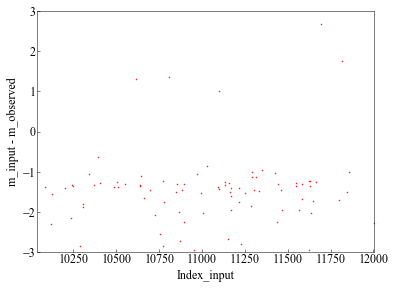

In [34]:
delr= tab3['delr']
iix = tab3['iix']
con_plot = (delr<10)

mag1 = data1['mag']
mag3 = data3['mag']

plt.plot(tab['id'][con_plot],(mag1[:]-mag3[iix])[con_plot],marker='.',ms=1,linestyle='')

plt.ylim(-3,3)
plt.ylabel('m_input - m_observed')
plt.xlabel('Index_input')

plt.savefig('mm_extended_pipelinecatalog.png')